In [28]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa.onset import onset_detect, onset_strength
from IPython.display import HTML, Audio
import librosa.display as ld
from sklearn.model_selection import train_test_split

from random import random, choice, randint

import torch
from torch.utils.data import Dataset, DataLoader

import pathlib, os

sns.set()

# Analisando metadados

In [2]:
# pegando os metadados
with open('./data/audioMNIST_meta.txt', 'r') as file:
    conteudo = json.load(file)

dados = []
for chave, cada_elemento in conteudo.items():
    dados.append(np.hstack([chave, [v for c,v in cada_elemento.items()]]))

df = pd.DataFrame(dados, columns=['chave', 'accent', 'age', 'gender', 'native', 'origin', 'date', 'name'])
df.head()

,chave,accent,age,gender,native,origin,date,name
0,01,german,30,male,no,"Europe, Germany, Wuerzburg",17-06-22-11-04-28,Kino
1,02,German,25,male,no,"Europe, Germany, Hamburg",17-06-26-17-57-29,Kino
2,03,German,31,male,no,"Europe, Germany, Bremen",17-06-30-17-34-51,Kino
3,04,German,23,male,no,"Europe, Germany, Helmstedt",17-06-30-18-09-14,Kino
4,05,German,25,male,no,"Europe, Germany, Hameln",17-07-06-10-53-10,Kino


# Listando os arquivos

In [3]:
sound_list = [str(l) for l in list(pathlib.Path('./data').glob('*/*')) if str(l).endswith('.wav')]
print (f'{len(sound_list)=}')

len(sound_list)=30000


# Carregando alguns exemplos aleatoriamente

data_array.shape=(12506,), sample_rate=22050


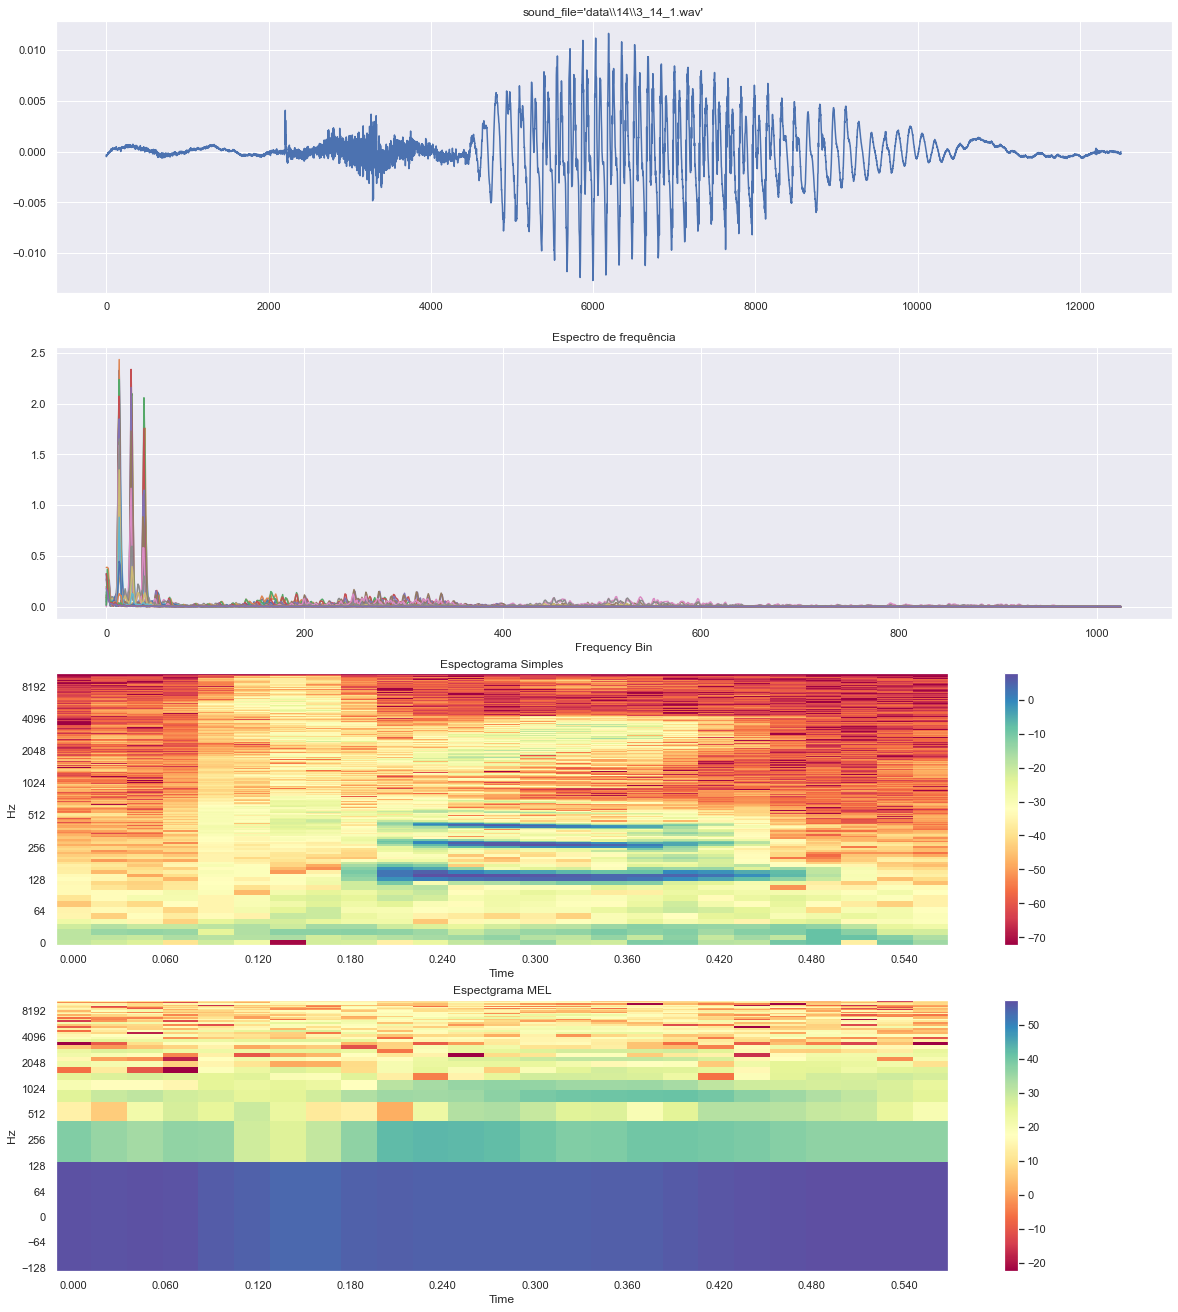

In [4]:
sound_file = choice(sound_list)
data_array, sample_rate = librosa.load(sound_file)
print (f'{data_array.shape=}, {sample_rate=}')

fourier_transf = np.abs(librosa.stft(data_array)) # aqui faz a transformada de fourier. Pegam as frequências e suas amplitudes
fourier_transf_db = librosa.amplitude_to_db(fourier_transf) # aqui as amplitudes são convertidas para db

mel_transf = np.abs(librosa.feature.mfcc(y = data_array, sr = sample_rate, n_mfcc=40))
mel_transf_db = librosa.amplitude_to_db(mel_transf)

plt.figure(figsize=(20, 23))
plt.subplot(4, 1, 1)
plt.plot(data_array)
plt.title(f'{sound_file=}')

plt.subplot(4, 1, 2)
plt.plot(fourier_transf)
plt.title('Espectro de frequência')
plt.xlabel('Frequency Bin')

plt.subplot(4, 1, 3)
img_spectral = librosa.display.specshow(fourier_transf_db, x_axis='time', y_axis='log', cmap='Spectral')
plt.colorbar(img_spectral)
plt.title('Espectograma Simples')

plt.subplot(4, 1, 4)
img_mel_spectral = librosa.display.specshow(mel_transf_db, x_axis='time', y_axis='log', cmap='Spectral')
plt.colorbar(img_mel_spectral)
plt.title('Espectgrama MEL')

plt.show()

Audio(data=data_array, rate=sample_rate)

# Criando uma função para extrair as features

In [10]:
def extrair_features(sound_path):
    data_array, sample_rate = librosa.load(sound_path, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y=data_array, sr=sample_rate, n_mfcc = 40)
        
    # Pegando as médias para o eixo 0
    return mfcc.mean(axis=1).reshape(1, -1)

sound_features = extrair_features(choice(sound_list))

# Criação do dataframe
- Além da divisão treino-teste para validação cruzada

In [24]:
df_sound = []
for cada_caminho in sound_list:
    # cada_caminho vem no formato: data\\50\\3_50_38.wav
    classe = int(cada_caminho.split('\\')[-1][0]) # o [-1] representa o último elemento enquanto o [0] representa o primeiro dígito
    df_sound.append([cada_caminho, classe])

df_sound = pd.DataFrame(df_sound, columns=['path', 'target'])

df_train, df_test = train_test_split(df_sound, test_size=0.1, shuffle=True, stratify=df_sound['target'])

print (f'{df_train.shape=}, {df_test.shape=}')

df_train.shape=(27000, 2), df_test.shape=(3000, 2)


# Criação da classe dataset

In [ ]:
class custom_dataset(Dataset):
    
    def __init__(self, df_):
        self.df_ = df_
    
    def __len__(self):
        return len(self.df_)
    
    def __getitem__(self, index):
        